<a href="https://colab.research.google.com/github/yaaili/test/blob/master/t2.0/13%E8%AF%AD%E4%B9%89%E5%88%86%E5%89%B2FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

os.chdir("/content/gdrive/My Drive/Colab Notebooks/tensorflow")


Mounted at /content/gdrive


# 1.导入相关的包

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

import glob
tf.__version__

'2.2.0'

# 2.数据的预处理
首先我们打印出一个图片和对应的分割图象

['._Bombay_27.png', '._Birman_91.png', '._Bombay_154.png', '._Bombay_22.png', '._Birman_93.png']


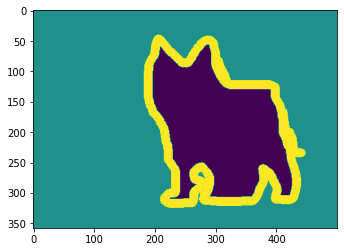

In [30]:
print(os.listdir("./DS/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps/")[-5:])
img = tf.io.read_file("./DS/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps/yorkshire_terrier_99.png")
img = tf.image.decode_png(img)
img = tf.squeeze(img)
plt.imshow(img)

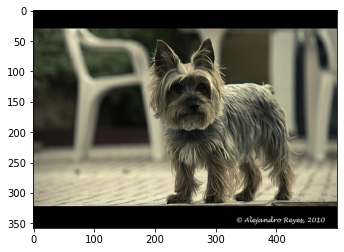

In [31]:
img1 = tf.io.read_file("./DS/the-oxfordiiit-pet-dataset/images/images/yorkshire_terrier_99.jpg")
img1 = tf.image.decode_png(img1)
plt.imshow(img1)

我们读取图片的路径和分割图片的的路径，并对其排序保证其一一对应，并随机打乱

In [32]:
#读取所有的图片
images = glob.glob("./DS/the-oxfordiiit-pet-dataset/images/images/*.jpg")
print(len(images))
anno = glob.glob("./DS/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps/*.png")
print(len(anno))

images.sort(key=lambda x :x.split("\\")[-1].split(".jpg")[0])
anno.sort(key=lambda x :x.split("\\")[-1].split(".png")[0])
#打乱
np.random.seed(2019)
index = np.random.permutation(len(images))
images = np.array(images)[index]
anno = np.array(anno)[index]

7390
7390


构建图片载入方法，主要包括读取原图像(jpg格式)，分割图像(png格式)，归一化函数和图像载入四个函数

In [0]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,channels=3)
    return img

def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=1)
    return img

# 归一化函数
def normal_img(input_images,input_anno):
    input_images = tf.cast(input_images,tf.float32)
    input_images = input_images/127.5 - 1
    input_anno = input_anno -1
    return input_images,input_anno

def load_image(input_images_path,input_anno_path):
    input_images = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    input_images = tf.image.resize(input_images,(224,224))
    input_anno = tf.image.resize(input_anno,(224,224))
    return normal_img(input_images,input_anno)

构建训练集和测试集，训练集的大小占总数据集的80%,bachsize=8，训练集有样本5912个，测试集有样本1478个。

In [34]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset = tf.data.Dataset.from_tensor_slices((images,anno))
dataset = dataset.map(load_image,num_parallel_calls=AUTOTUNE)
#%%设置训练数据和验证集数据的大小
test_count = int(len(images)*0.2)
train_count = len(images) - test_count
print(test_count,train_count)
#跳过test_count个
train_dataset = dataset.skip(test_count)
test_dataset = dataset.take(test_count)

batch_size = 8
# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据被充分打乱。
train_ds = train_dataset.shuffle(buffer_size=train_count).repeat().batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_dataset.batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

1478 5912


图片载入可视化实例

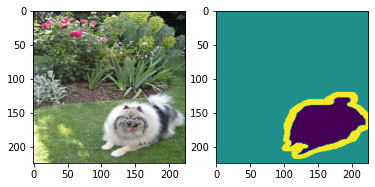

In [35]:
for image,anno in train_ds.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(anno[0]))

# 3.模型构建与训练
我们采用的VGG16作为预训练模型，输入的图像为(224,224,3)，采用全卷积网络（fully convolutional network，FCN）实现了从图像像素到像素类别的变换。与之前介绍的卷积神经网络有所不同，全卷积网络通过转置卷积（transposed convolution）层将中间层特征图的高和宽变换回输入图像的尺寸，从而令预测结果与输入图像在空间维（高和宽）上一一对应：给定空间维上的位置，通道维的输出即该位置对应像素的类别预测。

In [36]:
vgg16 = tf.keras.applications.VGG16(input_shape=(224, 224, 3), 
                          include_top=False,
                          weights='imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

我们定义的一个上采样的计算块

In [0]:
class Connect(tf.keras.layers.Layer):
    def __init__(self,
               filters=256,
               name='Connect',
               **kwargs):
        super(Connect, self).__init__(name=name, **kwargs)
    
        self.Conv_Transpose = tf.keras.layers.Convolution2DTranspose(filters=filters,
                                                                    kernel_size=3,
                                                                    strides=2,
                                                                    padding="same",
                                                                    activation="relu")
    
        self.conv_out = tf.keras.layers.Conv2D(filters=filters,
                                           kernel_size=3,
                                           padding="same",
                                           activation="relu")
    def call(self, inputs):
        x = self.Conv_Transpose(inputs)
        return self.conv_out(x)
    
    

为了提取更为一般的特征我们将vgg13网络的"block5_conv3","block4_conv3","block3_conv3",等不同深度层输出结果进行了跳级(skip)连接。

In [38]:
layer_names = ["block5_conv3",
               "block4_conv3",
               "block3_conv3",
               "block5_pool"]
#得到4个输出
layers_out = [vgg16.get_layer(layer_name).output for layer_name in layer_names] 
multi_out_model = tf.keras.models.Model(inputs = vgg16.input,
                                        outputs = layers_out)
multi_out_model.trainable = False

#创建输入
inputs = tf.keras.layers.Input(shape=(224,224,3))
out_block5_conv3,out_block4_conv3,out_block3_conv3,out = multi_out_model(inputs)
print(out_block5_conv3.shape)

x1 = Connect(512,name="connect_1")(out)
x1 = tf.add(x1,out_block5_conv3)#元素对应相加

x2 = Connect(512,name="connect_2")(x1)
x2 = tf.add(x2,out_block4_conv3)#元素对应相加

x3 = Connect(256,name="connect_3")(x2)
x3 = tf.add(x3,out_block3_conv3)#元素对应相加

x4 = Connect(128,name="connect_4")(x3)
 
prediction = tf.keras.layers.Convolution2DTranspose(filters=3,
                            kernel_size=3,
                            strides=2,
                            padding="same",
                            activation="softmax")(x4)

(None, 14, 14, 512)


In [39]:
prediction.shape
model = tf.keras.models.Model(inputs=inputs,outputs=prediction)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Model)                 [(None, 14, 14, 512) 14714688    input_6[0][0]                    
__________________________________________________________________________________________________
connect_1 (Connect)             (None, 14, 14, 512)  4719616     model_4[1][3]                    
__________________________________________________________________________________________________
tf_op_layer_Add_6 (TensorFlowOp [(None, 14, 14, 512) 0           connect_1[0][0]                  
                                                                 model_4[1][0]              

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="sparse_categorical_crossentropy",
        metrics=["acc"]
       )


In [41]:
steps_per_eooch = train_count//batch_size
validation_steps = test_count//batch_size

history = model.fit(train_ds,
            epochs=3,
            steps_per_epoch=steps_per_eooch,
            validation_data=test_ds,
            validation_steps=validation_steps)

Epoch 1/3
739/739 [==============================] - 293s 396ms/step - loss: 0.3794 - acc: 0.8461 - val_loss: 0.2967 - val_acc: 0.8797
Epoch 2/3
739/739 [==============================] - 292s 395ms/step - loss: 0.2823 - acc: 0.8848 - val_loss: 0.2743 - val_acc: 0.8897
Epoch 3/3
739/739 [==============================] - 292s 395ms/step - loss: 0.2572 - acc: 0.8947 - val_loss: 0.2631 - val_acc: 0.8935


In [42]:
validation_steps

184

# 5. 模型评估
从上面的训练中，我们迭代了三次就达到了，达到90%的准确率，从整体说效果是不错的，下面我们可视化一个图像，观察具体的预测效果。

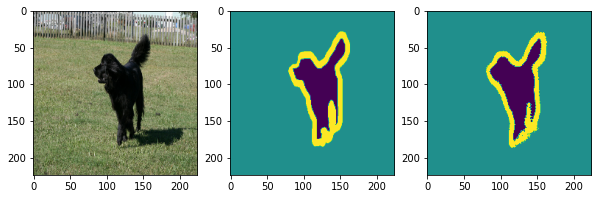

In [43]:
for image,mask in test_ds.take(1):
  pred_mask = model.predict(image)
  pred_mask = tf.argmax(pred_mask,axis=-1)
  pred_mask = pred_mask[...,tf.newaxis]
  plt.figure(figsize=(10,10))
  plt.subplot(1,3,1)
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
  plt.subplot(1,3,2)
  plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
  plt.subplot(1,3,3)
  plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[0]))